<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/Validation_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ../..

/


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit

# Utility Functions

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_temporal_cv_splits(cv, a):
    trn_idxs = []
    val_idxs = []
    datasets = {}  # nested dictionary for train/validation per split

    for split_id, (trn_idx, val_idx) in enumerate(cv.split(a)):
        trn_idxs.append((np.min(trn_idx), np.max(trn_idx)))
        val_idxs.append((np.min(val_idx), np.max(val_idx)))
        datasets[f"split_{split_id}"] = {
            "train": a[trn_idx],
            "validation": a[val_idx]
        }

    w = 0.8
    fig, ax = plt.subplots(figsize=(10, cv.get_n_splits() * 0.6))

    for x, ((trn_start, trn_end), (val_start, val_end)) in enumerate(zip(trn_idxs, val_idxs)):
        # train block
        ax.barh(y=x, width=trn_end - trn_start + 1, left=trn_start,
                height=w, color="#0356fc", edgecolor="#002570")
        # validation block
        ax.barh(y=x, width=val_end - val_start, left=val_start-1,
                height=w, color="#cf0053", edgecolor="#69002a")
        # gap block
        if trn_end != val_start-1:
            ax.barh(y=x, width=val_start - trn_end, left=trn_end,
                    height=w, color="#0f172e", edgecolor="#0f172e")

    ax.set_xlim(0, len(a))
    ax.set_ylim(-0.5, cv.get_n_splits() - 0.5)
    ax.set_yticks(range(cv.get_n_splits()))
    ax.set_yticklabels([f"split_{i}" for i in range(cv.get_n_splits())])
    ax.invert_yaxis()
    ax.set_xlabel("Index")
    ax.set_title("Temporal CV Splits")

    plt.show()

    return datasets


In [20]:
def plot_temporal_cv_splits(cv, a):
    trn_idxs = []
    val_idxs = []
    datasets = {}  # nested dictionary for train/validation per split

    for split_id, (trn_idx, val_idx) in enumerate(cv.split(a)):
        trn_idxs.append((np.min(trn_idx), np.max(trn_idx)))
        val_idxs.append((np.min(val_idx), np.max(val_idx)))
        datasets[f"split_{split_id}"] = {
            "train": a[trn_idx],
            "validation": a[val_idx]
        }

    w = 0.8
    y = np.arange(len(trn_idxs)) + 1
    fig = go.Figure()

    for x, ((trn_start, trn_end), (val_start, val_end)) in enumerate(zip(trn_idxs, val_idxs)):
        fig.add_shape(
            type="rect", y0=x, y1=x+w, x0=trn_start, x1=trn_end,
            fillcolor="#0356fc", line=dict(color="#002570", width=0.5),
        )
        fig.add_shape(
            type="rect", y0=x, y1=x+w, x0=val_start-1, x1=val_end-1,
            fillcolor="#cf0053", line=dict(color="#69002a", width=0.5),
        )
        if trn_end != val_start-1:
            # plotting gap
            fig.add_shape(
                type="rect", y0=x, y1=x+w, x0=trn_end, x1=val_start,
                fillcolor="#0f172e", line=dict(color="#0f172e", width=0.5),
            )

    fig.update_xaxes(range=[0, len(a)])
    fig.update_yaxes(range=[cv.get_n_splits(), 0])

    return fig, datasets


In [32]:
from itertools import groupby
from operator import itemgetter

def plot_cv_splits(cv, a):
    w = 0.8
    y = np.arange(cv.get_n_splits()) + 1
    _range = np.arange(len(a))
    fig = go.Figure()
    datasets = {}  # nested dictionary for train/validation per split

    for split_id, (trn_idx, val_idx) in enumerate(cv.split(a)):
        # store train/validation data
        datasets[f"split_{split_id}"] = {
            "train": a[trn_idx],
            "validation": a[val_idx]
        }

        val_mask = np.isin(_range, val_idx)
        trn_mask = np.isin(_range, trn_idx)
        gap_mask = np.logical_not(np.logical_xor(trn_mask, val_mask))

        fig.add_shape(
            type="rect", y0=split_id, y1=split_id+w, x0=0, x1=len(a),
            fillcolor="#0356fc", line=dict(color="#002570", width=0.5),
        )
        fig.add_shape(
            type="rect", y0=split_id, y1=split_id+w,
            x0=np.min(val_idx)-1, x1=np.max(val_idx),
            fillcolor="#cf0053", line=dict(color="#69002a", width=0.5),
        )

        if gap_mask.sum() > 0:
            # plotting gap
            gap = _range[gap_mask]
            # splitting based on continuous gap
            for k, g in groupby(enumerate(gap), lambda i_x: i_x[0] - i_x[1]):
                _gap = list(map(itemgetter(1), g))
                gap_min, gap_max = np.min(_gap), np.max(_gap)
                fig.add_shape(
                    type="rect", y0=split_id, y1=split_id+w,
                    x0=gap_min-1, x1=gap_max,
                    fillcolor="#0f172e", line=dict(color="#0f172e", width=0.5),
                )

    fig.update_xaxes(range=[0, len(a)])
    fig.update_yaxes(range=[0, cv.get_n_splits()])

    return fig, datasets


# Validation Strategies

In [41]:
N = 50
a = np.arange(N)

## 1.Repeated Holdout with no Overlap (Expanding Window)

In [47]:
cv = TimeSeriesSplit(n_splits=5, test_size = 5)
fig, datasets = plot_temporal_cv_splits(cv, a)
fig.update_layout(width=900, height=500)
fig.show()

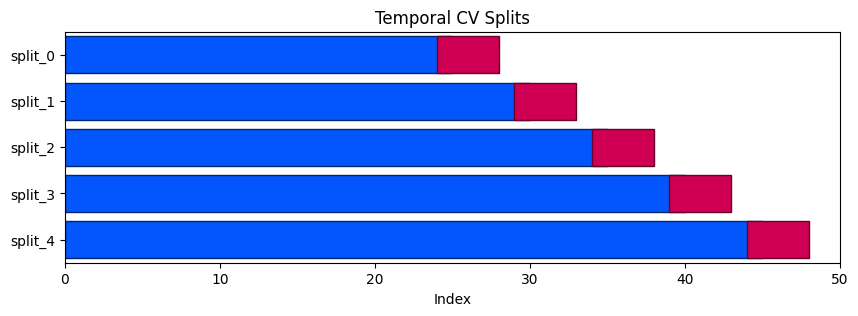

In [49]:
cv = TimeSeriesSplit(n_splits=5, test_size = 5)
datasets = plot_temporal_cv_splits(cv, a)


In [50]:

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

,train,validation
split_0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[25, 26, 27, 28, 29]"
split_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[30, 31, 32, 33, 34]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[35, 36, 37, 38, 39]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[40, 41, 42, 43, 44]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[45, 46, 47, 48, 49]"


## 2.Repeated Holdout with no Overlap (Rolling Window)

In [29]:
cv = TimeSeriesSplit(n_splits=5, max_train_size=10)
fig,datasets = plot_temporal_cv_splits(cv, a)
fig.update_layout(width=900, height=500)
fig.show()

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

,train,validation
split_0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17]"
split_1,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[18, 19, 20, 21, 22, 23, 24, 25]"
split_2,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25]","[26, 27, 28, 29, 30, 31, 32, 33]"
split_3,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33]","[34, 35, 36, 37, 38, 39, 40, 41]"
split_4,"[32, 33, 34, 35, 36, 37, 38, 39, 40, 41]","[42, 43, 44, 45, 46, 47, 48, 49]"


## 3.Repeated Holdout with no Overlap with Gaps (Expanding Window)

In [30]:
cv = TimeSeriesSplit(n_splits=5, gap=5)
fig, datasets = plot_temporal_cv_splits(cv, a)
fig.update_layout(width=900, height=500)
fig.show()

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

,train,validation
split_0,"[0, 1, 2, 3, 4]","[10, 11, 12, 13, 14, 15, 16, 17]"
split_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[18, 19, 20, 21, 22, 23, 24, 25]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26, 27, 28, 29, 30, 31, 32, 33]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[34, 35, 36, 37, 38, 39, 40, 41]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[42, 43, 44, 45, 46, 47, 48, 49]"


## 4.Repeated Holdout with no Overlap with Gaps (Rolling Window)

In [31]:
cv = TimeSeriesSplit(n_splits=5, max_train_size=10, gap=5)
fig,datasets = plot_temporal_cv_splits(cv, a)
fig.update_layout(width=900, height=500)
fig.show()

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

,train,validation
split_0,"[0, 1, 2, 3, 4]","[10, 11, 12, 13, 14, 15, 16, 17]"
split_1,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[18, 19, 20, 21, 22, 23, 24, 25]"
split_2,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[26, 27, 28, 29, 30, 31, 32, 33]"
split_3,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28]","[34, 35, 36, 37, 38, 39, 40, 41]"
split_4,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","[42, 43, 44, 45, 46, 47, 48, 49]"


## 5.Blocked Cross-Validation

In [11]:
from sklearn.model_selection import KFold

In [33]:
cv = KFold(n_splits=5, shuffle=False) #blocked CV

fig, datasets = plot_cv_splits(cv, a)
fig.update_layout(width=900, height=500)
fig.show()

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

,train,validation
split_0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
split_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23,...","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]"


## 6.Blocked Cross-Validation with Gaps

In [34]:
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import _num_samples, indexable

In [35]:
class KFoldGap(_BaseKFold):
    def __init__(self, n_splits=5, gap=0, *, random_state=None):
        self.gap = gap
        super().__init__(n_splits=n_splits, shuffle=False, random_state=random_state)

    def _iter_test_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        indices = np.arange(n_samples)
        n_splits = self.n_splits
        fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
        fold_sizes[: n_samples % n_splits] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            yield start,stop
            current = stop

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        indices = np.arange(_num_samples(X))
        for test_start, test_stop in self._iter_test_indices(X, y, groups):
            test_index = indices[test_start:test_stop]
            inv_train_index = indices[max(test_start-self.gap,0):test_stop+self.gap]
            test_mask = np.zeros(_num_samples(X), dtype=bool)
            test_mask[inv_train_index] = True
            train_index = indices[np.logical_not(test_mask)]
            yield train_index, test_index

In [36]:
cv = KFoldGap(n_splits=5, gap=5) #blocked CV
fig, datasets = plot_cv_splits(cv, a)
fig.update_layout(width=900, height=500)
fig.show()

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

,train,validation
split_0,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
split_1,"[0, 1, 2, 3, 4, 25, 26, 27, 28, 29, 30, 31, 32...","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]"
